# Semi-Markov to Markov Tokenization

In [11]:
from genparse import CFGLM, CFG, Chart, Float as Real
from genparse.cfglm import explode, add_EOS, EOS, SPACER
from genparse.steer import normalize, sample_dict, normalize
from genparse.align import pullback, ERROR
from genparse.inference import TraceSWOR
from genparse import align
from collections import Counter

In [12]:
cfg = CFG.from_string(
    """

1: S -> A A A A
1: A -> a 
1: A -> aa
1: A -> b
1: A -> bb

""",
    Real,
)

In [13]:
lm = CFGLM(cfg.cnf)

In [14]:
char_lm = CFGLM(explode(cfg).cnf)

In [15]:
prefix = 'aa#a#a#'
display(char_lm.p_next(prefix))
display(pullback(char_lm, prefix))

key,value
a,2.0
b,2.0


key,value
a,2.0
b,2.0


In [16]:
cfg1 = add_EOS(
    CFG.from_string(
        """

.8: S -> A S
.2: S ->
.1: A -> john
.3: A -> jo
.1: A -> johnny
.1: A -> jonathan
.1: A -> nathan
.1: A -> hates
.2: A -> loves

""",
        Real,
    )
)

In [17]:
cfg1.agenda()

key,value
hates,1
jonathan,1
jo,1
johnny,1
nathan,1
▪,1
john,1
loves,1
A,1.0
S,0.999999999995413


In [18]:
lm1 = CFGLM(cfg1)

In [19]:
char_lm1 = CFGLM(explode(cfg1))

In [20]:
lm1.p_next(())

key,value
loves,0.15999999999926612
johnny,0.07999999999963306
jo,0.23999999999889915
jonathan,0.07999999999963306
john,0.07999999999963306
hates,0.07999999999963306
▪,0.2
nathan,0.07999999999963306


In [21]:
char_lm1.p_next(())

key,value
n,0.07999999999963303
▪,0.2
h,0.07999999999963303
j,0.4799999999977982
l,0.15999999999926606


In [22]:
cfg2 = add_EOS(
    CFG.from_string(
        """

0.25: S -> john loves jo
0.25: S -> jo hates jonathan
0.25: S -> jo loves johnny
0.25: S -> nathan loves nathan

""",
        Real,
    )
)
cfg2

Grammar {
  1: <START>@72 → S ▪
  0.25: S → john loves jo
  0.25: S → jo hates jonathan
  0.25: S → jo loves johnny
  0.25: S → nathan loves nathan
}

In [23]:
cfg2.agenda()

key,value
nathan,1
hates,1
▪,1
john,1
jonathan,1
jo,1
johnny,1
loves,1
S,1.0
@72,1.0


In [24]:
lm2 = CFGLM(cfg2)

In [25]:
lm2.p_next(())

key,value
jo,0.5
john,0.25
nathan,0.25


In [26]:
char_lm2 = CFGLM(explode(cfg2))

In [27]:
char_lm2.p_next(())

key,value
n,0.25
j,0.75


The most obvious way to synchronize the LMs is to explode them so they generate individual characters.

In [28]:
align.char_char_sync(
    char_lm1,
    char_lm2,
)

('jo#hates#jonathan#▪', 0.23684210526315788)

In [29]:
tracer = TraceSWOR()
samples = []
while tracer.root.mass > 0:
    with tracer:
        got = align.char_char_sync(char_lm1, char_lm2, draw=tracer)
    samples.append(got)
    print(got)

('jo#loves#johnny#▪', 0.47368421052631576)
('nathan#loves#nathan#▪', 0.05263157894736842)
('jo#hates#jonathan#▪', 0.23684210526315788)
('john#loves#jo#▪', 0.23684210526315788)


In [30]:
sum(p for _, p in samples)

0.9999999999999999

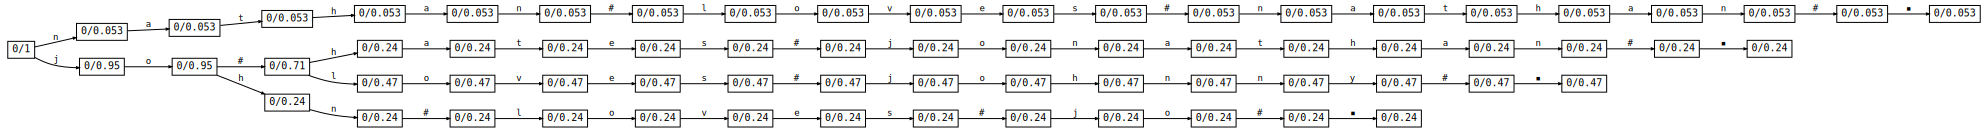

In [31]:
tracer.root.graphviz()

Another option is to have a single character-level model and to use it to score the character sequences proposed by the string-level model.

In [32]:
align.string_char_sync(lm1, char_lm2)

('jo#loves#johnny#▪', 0.5)

In [33]:
tracer = TraceSWOR()
samples = []
while tracer.root.mass > 0:
    with tracer:
        got = align.string_char_sync(lm1, char_lm2, draw=tracer)
    #    display(tracer.root.graphviz())
    print(got)
    samples.append(got)

('jo#hates#jonathan#▪', 0.25)
('john#loves#jo#▪', 0.12500000000000003)
('nathan#loves#nathan#▪', 0.12500000000000003)
('jo#loves#johnny#▪', 0.5)


In [34]:
sum(p for _, p in samples)

1.0

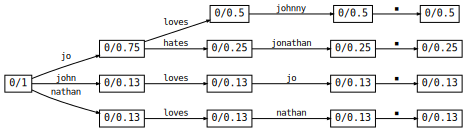

In [35]:
tracer.root.graphviz(fmt_node=lambda x: f'{x.mass}/{x._mass:.2g}')

In [36]:
N = 10_000
a = Counter([align.char_char_sync(char_lm1, char_lm2)[0] for _ in range(N)])
b = Counter([align.string_char_sync(lm1, char_lm2)[0] for _ in range(N)])

In [37]:
normalize(a)

Counter({'jo#loves#johnny#▪': 0.4802,
         'jo#hates#jonathan#▪': 0.2382,
         'john#loves#jo#▪': 0.2325,
         'nathan#loves#nathan#▪': 0.0491})

In [38]:
normalize(b)

Counter({'jo#loves#johnny#▪': 0.497,
         'jo#hates#jonathan#▪': 0.2514,
         'nathan#loves#nathan#▪': 0.126,
         'john#loves#jo#▪': 0.1256})

In [39]:
dict(samples)

{'jo#hates#jonathan#▪': 0.25,
 'john#loves#jo#▪': 0.12500000000000003,
 'nathan#loves#nathan#▪': 0.12500000000000003,
 'jo#loves#johnny#▪': 0.5}